In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Hyprerparameters

In [20]:
np.random.seed(1)
torch.manual_seed(1)
LR = 5e-3
BATCH_SIZE = 64
EPOCH = 7000
# for 2nd training
EPOCH2 = 1000
USE_CUDA = torch.cuda.is_available()

## Generate Data

In [4]:
def sample_func(x):
    return np.sinc(x)

In [15]:
train_x = (2 * np.random.rand(2000)-1) * 3
train_y = sample_func(train_x)
train_x, train_y = Variable(torch.FloatTensor(train_x)), Variable(torch.FloatTensor(train_y))
train_x = train_x.unsqueeze(1)
train_y = train_y.unsqueeze(1)

## Define Network Structure

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 30)
        self.fc2 = nn.Linear(30, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

## Set Optimizer and Loss

In [16]:
net = Net()
if USE_CUDA:
    net.cuda()
    train_x.cuda()
optimizer = optim.Adam(params=net.parameters(), lr=LR)
optimizer_Newton = optim.LBFGS(params=net.parameters(), lr=LR)
loss_func = nn.MSELoss()

## Some Helper Functions

In [8]:
def calculate_grad(model):
    grad_all = 0
    for layer in model.parameters():
        if layer.grad is not None:
            grad = (layer.grad.data.numpy() **2).sum()
            grad_all += grad
    return grad_all

# this function can add grad into computational graph
def calculate_grad2(model):
    grad_norm = 0
    grad_params = torch.autograd.grad(loss, model.parameters(), create_graph=True, retain_graph=True)
    for grad in grad_params:
        grad_norm += grad.pow(2).sum()
    return grad_norm

def minimal_ratio(matrix):
    w, _ = np.linalg.eig(matrix)
    return (w > 0).mean()

# dosent work ...
def calculate_hessian(loss, model):
    var = model.parameters()
    temp = []
    grads = torch.autograd.grad(loss, var, create_graph=True)
    grads = torch.cat([g.view(-1) for g in grads])
    for grad in grads:
        grad2 = torch.autograd.grad(grad, var, create_graph=True)
        temp.append(grad2)
    return np.array(temp)

# return a layer-structured hessian matrix (bad)
def calculate_hessian2(loss, model):
    var = [ i for i in model.parameters()]
    temp = []
    grads = torch.autograd.grad(loss, var, create_graph=True, retain_graph=True)
    for layer in grads:
        for grad in layer:
            for g in grad:
                temp2 = []
#                 g.backward(retain_graph=True)
                for v in var:
                    grad2 = torch.autograd.grad(g, v, create_graph=True, retain_graph=True)
                    for grd in grad2:
                        temp2.append(grd)
                temp.append(temp2)
    return np.array(temp)

# return a 2D hessian matrix (good)
def calculate_hessian3(loss, model):
    var = [ i for i in model.parameters()]
    hessian = torch.zeros(1)
    grads = torch.autograd.grad(loss, var, create_graph=True, retain_graph=True)
    for layer in grads:
        for grad in layer:
            for g in grad:
                temp2 = []
                for v in var:
                    grad2 = torch.autograd.grad(g, v, create_graph=True, retain_graph=True)
                    for grd in grad2:
                        hessian = torch.cat((hessian, grd.data.view(-1)), 0)
    size = int(np.sqrt(hessian.size()))
    return np.array(hessian[1:].view(size, size))

## little test

In [9]:
minimal_ratio(np.diag([1,-1,-1]))

0.3333333333333333

## Train

epoch:    0 | loss: 0.195695 | grad: 2.164435


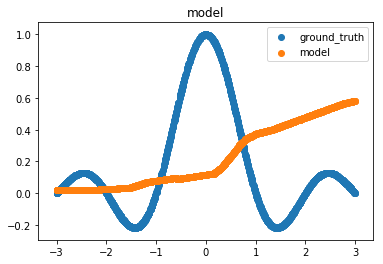

epoch: 1000 | loss: 0.001310 | grad: 0.000000


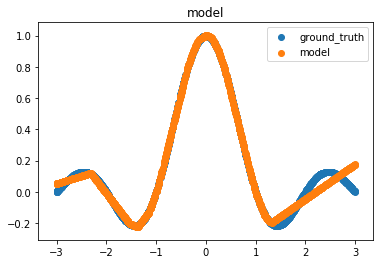

epoch: 2000 | loss: 0.001249 | grad: 0.000000


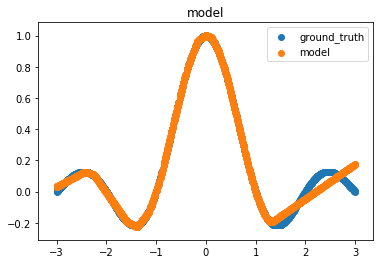

epoch: 3000 | loss: 0.001237 | grad: 0.000000


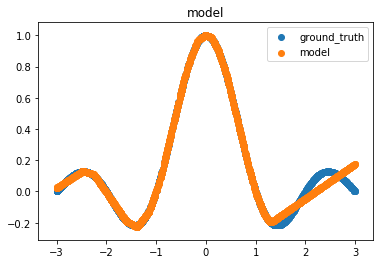

epoch: 4000 | loss: 0.001510 | grad: 0.039580


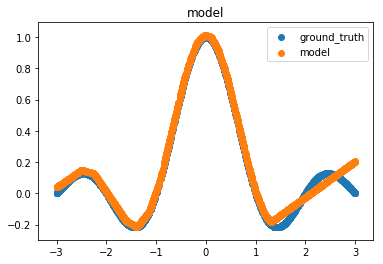

epoch: 5000 | loss: 0.001231 | grad: 0.000000


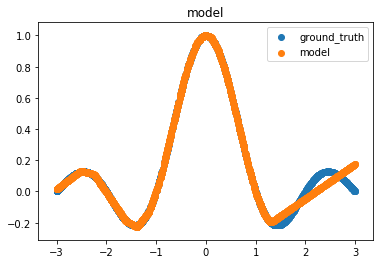

epoch: 6000 | loss: 0.001230 | grad: 0.000000


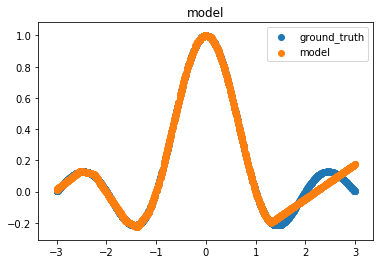

In [17]:
# normal
grad_list = []
loss_list = []
for epoch in range(EPOCH):
    pred = net(train_x)
    loss = loss_func(pred, train_y)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    grad_list.append(calculate_grad(net))
    loss_list.append(loss.data[0])
    
    if epoch % 1000 == 0:
        print('epoch: %4d | loss: %.6f | grad: %.6f' % (epoch, loss.data[0], calculate_grad(net)))
        plt.figure()
        plt.scatter(train_x, train_y, label="ground_truth")
        plt.scatter(train_x, pred.data, label="model")
        plt.title("model")
        plt.legend()
        plt.show()
        

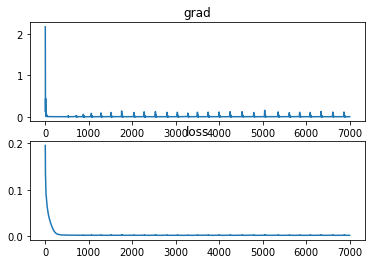

In [18]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(np.arange(EPOCH), (np.array(grad_list)))
ax[1].plot(np.arange(EPOCH), (np.array(loss_list)))
ax[0].set_title('grad')
ax[1].set_title('loss')
plt.show()

epoch:    0 | loss: 0.002568 | grad: 9.349234


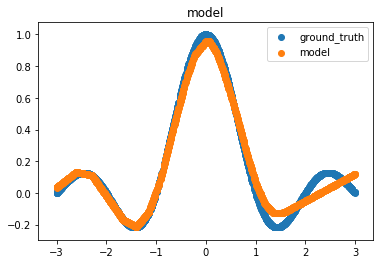

epoch:  100 | loss: 0.002536 | grad: 0.000736


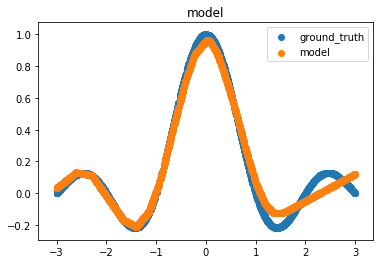

epoch:  200 | loss: 0.002510 | grad: 0.000070


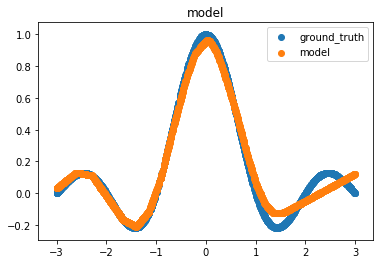

epoch:  300 | loss: 0.002484 | grad: 0.000065


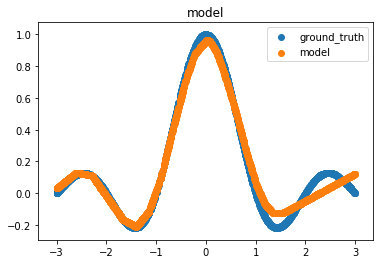

epoch:  400 | loss: 0.002457 | grad: 0.000060


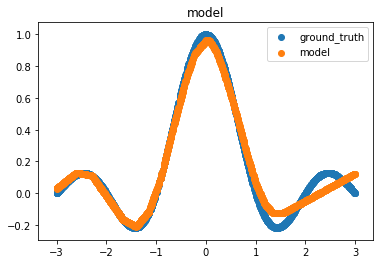

epoch:  500 | loss: 0.002431 | grad: 0.000055


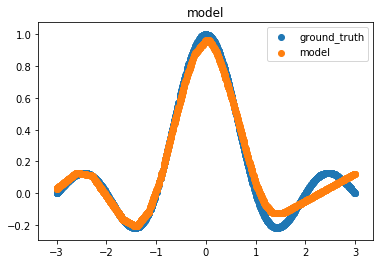

epoch:  600 | loss: 0.002405 | grad: 0.000051


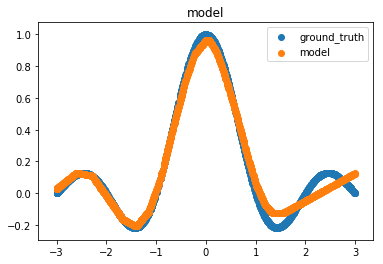

epoch:  700 | loss: 0.002380 | grad: 0.000046


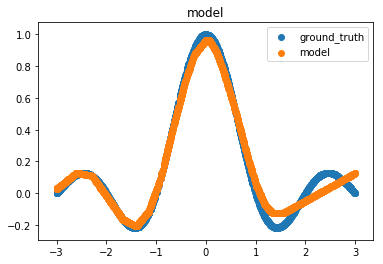

epoch:  800 | loss: 0.002354 | grad: 0.000042


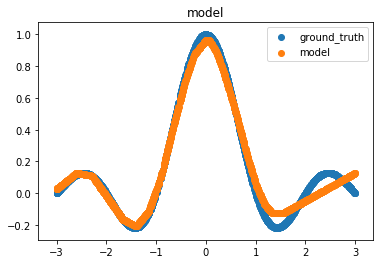

epoch:  900 | loss: 0.002329 | grad: 0.000038


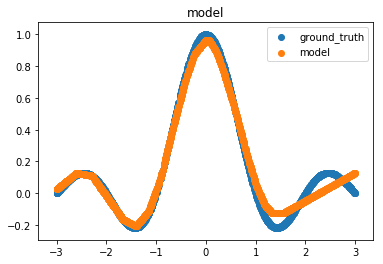

In [21]:
# minimize grad
grad_list2 = []
loss_list2 = []

for epoch in range(EPOCH2):
    pred = net(train_x)
    loss = loss_func(pred, train_y)
    optimizer.zero_grad()
    
    # instead of backward by loss, this time backward by grad_norm
    grad_norm = calculate_grad2(net)
    grad_norm.backward(retain_graph=True)
        
    optimizer.step()
    
    grad_list2.append(calculate_grad(net))
    loss_list2.append(loss.data[0])
    
    if epoch % 100 == 0:
        print('epoch: %4d | loss: %.6f | grad: %.6f' % (epoch, loss.data[0], calculate_grad(net)))
        plt.figure()
        plt.scatter(train_x, train_y, label="ground_truth")
        plt.scatter(train_x, pred.data, label="model")
        plt.title("model")
        plt.legend()
        plt.show()
        

In [24]:
hessian = calculate_hessian3(loss, net)
min_ratio = minimal_ratio(hessian)
print(min_ratio)

0.6483516483516484


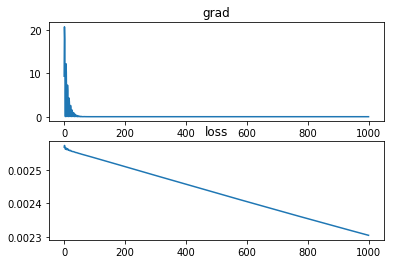

In [23]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(np.arange(EPOCH2), (np.array(grad_list2)))
ax[1].plot(np.arange(EPOCH2), (np.array(loss_list2)))
ax[0].set_title('grad')
ax[1].set_title('loss')
plt.show()

## (Reference)To Calculate Higher Order Gradient
https://github.com/pytorch/pytorch/releases/tag/v0.2.0
```python
import torch
from torchvision.models import resnet18
from torch.autograd import Variable

model = resnet18().cuda()

# dummy inputs for the example
input = Variable(torch.randn(2,3,224,224).cuda(), requires_grad=True)
target = Variable(torch.zeros(2).long().cuda())

# as usual
output = model(input)
loss = torch.nn.functional.nll_loss(output, target)

grad_params = torch.autograd.grad(loss, model.parameters(), create_graph=True)
# torch.autograd.grad does not accumuate the gradients into the .grad attributes
# It instead returns the gradients as Variable tuples.

# now compute the 2-norm of the grad_params
grad_norm = 0
for grad in grad_params:
    grad_norm += grad.pow(2).sum()
grad_norm = grad_norm.sqrt()

# take the gradients wrt grad_norm. backward() will accumulate
# the gradients into the .grad attributes
grad_norm.backward()

# do an optimization step
optimizer.step()
```

## (Reference) 
https://discuss.pytorch.org/t/calculating-hessian-vector-product/11240/3
```python
v = Variable(torch.Tensor([1, 1]))
x = Variable(torch.Tensor([0.1, 0.1]), requires_grad=True)
f = 3 * x[0] ** 2 + 4 * x[0] * x[1] + x[1] **2
grad_f, = torch.autograd.grad(f, x, create_graph=True)
z = grad_f @ v
```

In [ ]:
##TEST SECTION##
a = torch.FloatTensor([1])
b = torch.FloatTensor([3])

a, b = Variable(a, requires_grad=True), Variable(b, requires_grad=True)

c = a + 3 * b**2
c = c.sum()

grad_b = torch.autograd.grad(c, b, create_graph=True)
grad2_b = torch.autograd.grad(grad_b, b, create_graph=True)

print(grad2_b)